In [2]:
# load the required packages
import os
import sys
import psycopg2
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path

import plotly.io as pio
import plotly.graph_objects as go

# adds the package path to the Python path to make sure all the local imports work fine 
if os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))) not in sys.path:
    sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

# local imports 
from wp4.constants import POLLUTANTS, DB_HOST, DB_NAME, DB_USER, DB_PASS, DATA_DIR_CAMS_AN, DATA_DIR_PLOTS
from wp4.baseline.spatial import get_spatial_baseline
from wp4.baseline.temporal import get_temporal_baseline
from wp4.baseline.spatiotemporal import get_spatiotemporal_baseline

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os, sys
import xarray as xr 
import pandas as pd
import psycopg2
import geopandas as gpd
import matplotlib.ticker as mtick

In [3]:
POLLUTANTS_TO_ANALYSE = POLLUTANTS.keys() # 'PM10','SO2','CO', 'O3', 'NO', 'NO2'  

In [4]:
OUTPUT_DIR = Path(DATA_DIR_PLOTS).joinpath('baseline_deviation')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [30]:
csv_loc = Path(DATA_DIR_PLOTS).joinpath('analysis/baseline_deviation/temporal/csv')

pollutant_difference_percent_pol_tp = {}

for pol in POLLUTANTS_TO_ANALYSE:  # 'SO2','CO', 'O3', 'NO', 'NO2',
    
    df_perc = pd.read_csv(f'{csv_loc}/{pol}_percentage.csv', header=1).set_index('hours_from_fe')
    
    pollutant_difference_percent_pol_tp[pol] = df_perc.copy()

In [31]:
csv_loc = Path(DATA_DIR_PLOTS).joinpath('analysis/baseline_deviation/spatial/csv')

pollutant_difference_percent_pol_sp = {}

for pol in POLLUTANTS_TO_ANALYSE:  # 'SO2','CO', 'O3', 'NO', 'NO2',
    
    df_perc = pd.read_csv(f'{csv_loc}/{pol}_percentage.csv', header=1).set_index('hours_from_fe')
    
    pollutant_difference_percent_pol_sp[pol] = df_perc.copy()

In [32]:
csv_loc = Path(DATA_DIR_PLOTS).joinpath('analysis/baseline_deviation/spatiotemporal/csv')

pollutant_difference_percent_pol_sptp = {}

for pol in POLLUTANTS_TO_ANALYSE:  # 'SO2','CO', 'O3', 'NO', 'NO2',
    
    df_perc = pd.read_csv(f'{csv_loc}/{pol}_percentage.csv', header=1).set_index('hours_from_fe')
    
    pollutant_difference_percent_pol_sptp[pol] = df_perc.copy()

In [10]:
def get_baseline_stats(df):
    
    df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
    
    pol_df = df.quantile([.1, .25, .5, .75, .9]) # calculate percentiles
    mean_df = df.mean() # mean
    std_dev_df = df.std()  # standard deviation
    
    return pol_df, mean_df, std_dev_df

In [37]:
 

TEMPLATE = pio.templates["ggplot2"]

for pol in POLLUTANTS_TO_ANALYSE: #
    
    df_spatial = pollutant_difference_percent_pol_sp[pol]
    
    pol_df_sp, mean_df_sp, std_dev_df_sp = get_baseline_stats(df_spatial)
    
    df_temporal = pollutant_difference_percent_pol_tp[pol]
    
    pol_df_tp, mean_df_tp, std_dev_df_tp = get_baseline_stats(df_temporal)
    
    df_spatiotemporal = pollutant_difference_percent_pol_sptp[pol]
    
    pol_df_sptp, mean_df_sptp, std_dev_df_sptp = get_baseline_stats(df_spatiotemporal)

    fig = go.Figure()
    
    cols = [int(float(col)) for col in pol_df_temporal.columns] # get the value range for the x axis, 

    fig.add_trace(go.Scatter(
        x=cols,
        y=pol_df_sp.loc[0.5].rolling(6, min_periods=1).mean(),
        mode='lines',
        line_color='#5e60ce',
        name='Median Spatial Baseline'
    ))
    
    fig.add_trace(go.Scatter(
        x=cols,
        y=pol_df_tp.loc[0.5].rolling(6, min_periods=1).mean(),  # .rolling() add rolling window
        mode='lines',
        line_color='#38b000',
        name='Median Temporal Baseline'
    ))
    
    fig.add_trace(go.Scatter(
        x=cols,
        y=pol_df_sptp.loc[0.5].rolling(6, min_periods=1).mean(),
        mode='lines',
        line_color='purple',
        name='Median Spatiotemporal Baseline'
    ))
        
    fig.update_layout(
                title=f'{POLLUTANTS[pol]["FULL_NAME"]} ({POLLUTANTS[pol]["FORMULA_HTML"]}) deviation from baseline (in %)',
                xaxis_title="Days from Fire Event",
                yaxis_title="Deviation from Baseline in %",
                legend_title="Legend",
                )# Add shapes
    
    fig.update_layout(
                legend = {'font_size': 14},
                template=TEMPLATE,
                xaxis = dict(
                    tickmode = 'array',
                    tick0 = df_spatial.reset_index()['hours_from_fe'][0],
                    dtick = 24))
    
    fig.add_vline(x=0, line_width=4, line_color="orange")
    
    fig.update_xaxes(
        ticktext = [
            f'{int(x/24)} Days Before' if x < 0 else f'{int(x/24)} Days After'.replace("0 Days After", "Fire Event") for x in list(
                range(
                    int(float(list(df_spatial.columns)[0])),
                    int(float(list(df_spatial.columns)[-1])),
                    24
                )
            )
        ],
        tickvals=[str(x) for x in list(
            range(
                    int(float(list(df_spatial.columns)[0])),
                    int(float(list(df_spatial.columns)[-1])),
                    24
                )
        )]
    )
    
    fig.show()

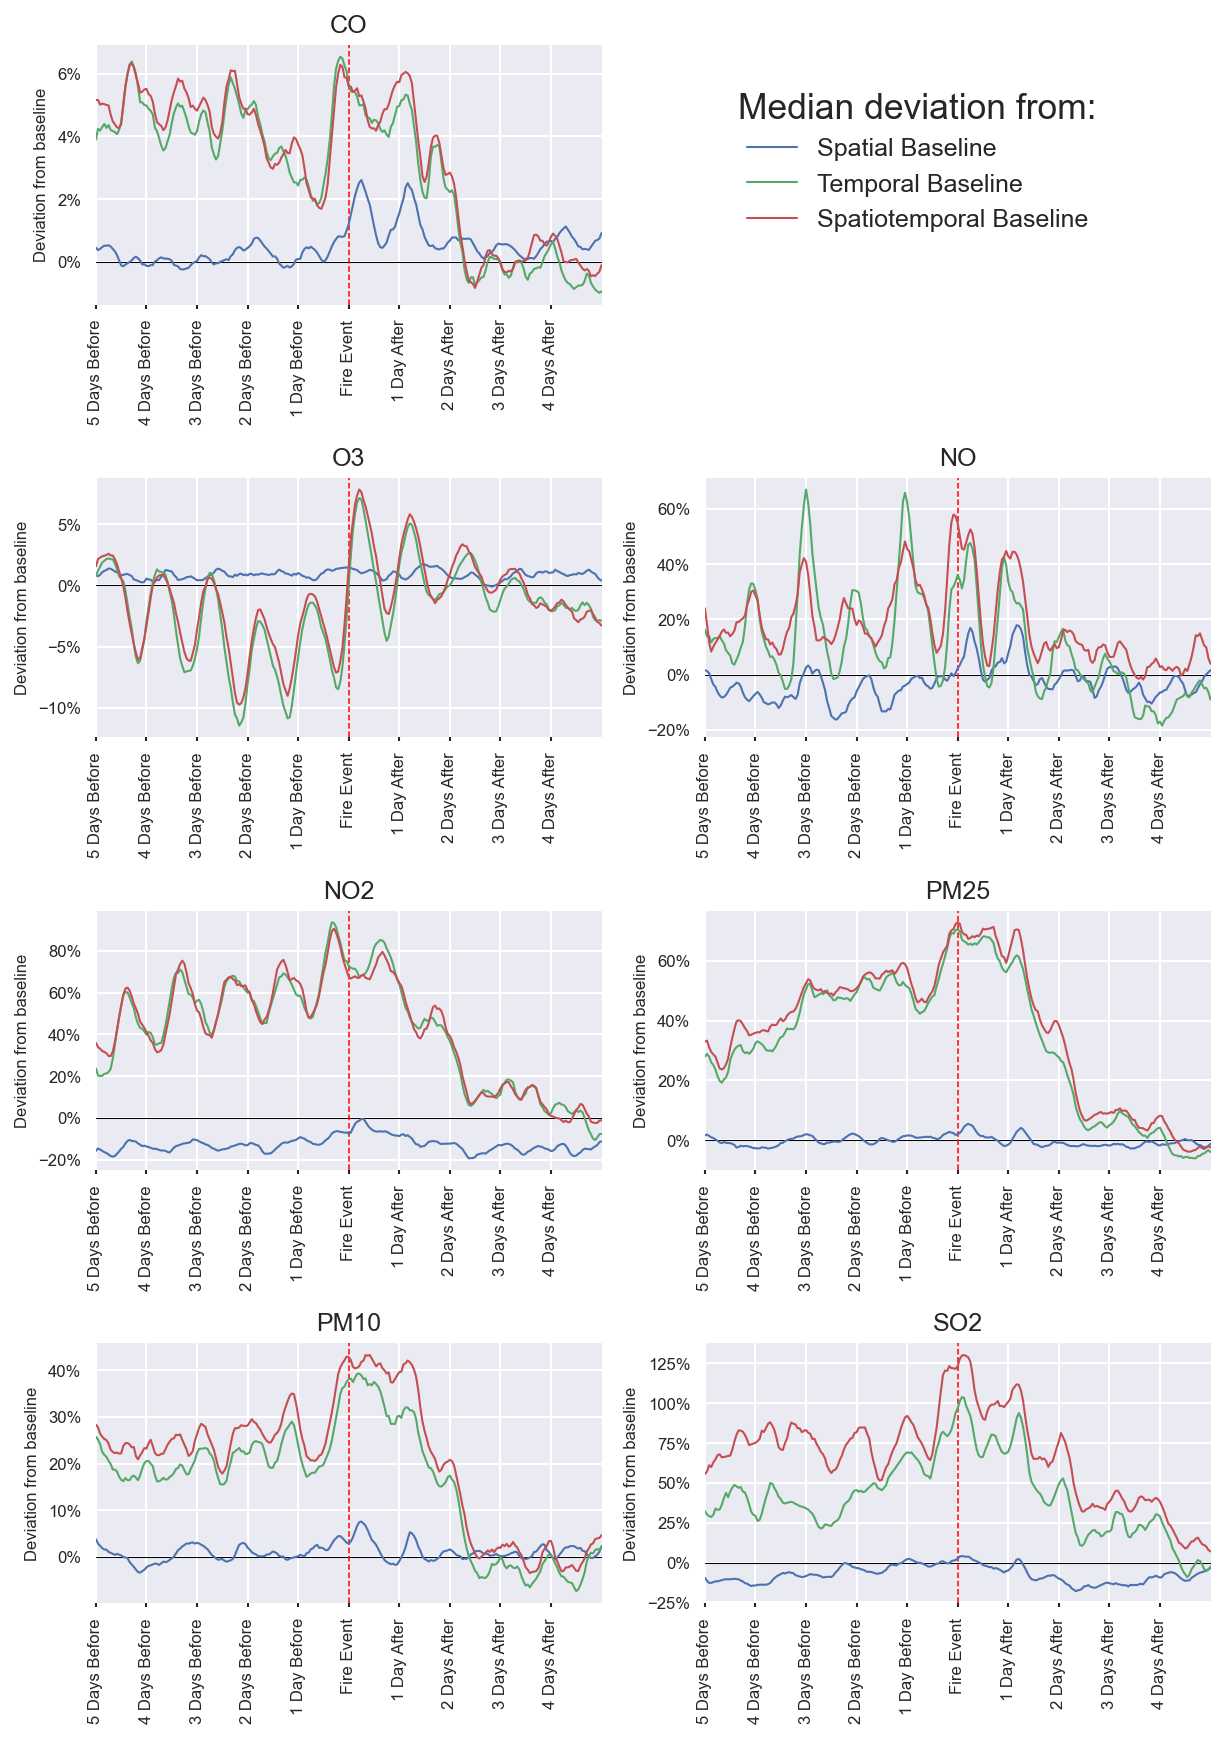

In [188]:
plt.style.use('seaborn')
fig, ax = plt.subplots(4,2, figsize=(8.27, 11.69), dpi=150)
# fig.suptitle('CAMS Reanalysis pollutant distribution per hour of the day for Ireland in 2018.')


positions = {
    0:ax[0][0],
    1:ax[1][0],
    2:ax[1][1],
    3:ax[2][0],
    4:ax[2][1],
    5:ax[3][0],
    6:ax[3][1],
}

for ind, pol in enumerate(POLLUTANTS):
    
    df_spatial = pollutant_difference_percent_pol_sp[pol]
    
    pol_df_sp, mean_df_sp, std_dev_df_sp = get_baseline_stats(df_spatial)
    
    df_temporal = pollutant_difference_percent_pol_tp[pol]
    
    pol_df_tp, mean_df_tp, std_dev_df_tp = get_baseline_stats(df_temporal)
    
    df_spatiotemporal = pollutant_difference_percent_pol_sptp[pol]
    
    pol_df_sptp, mean_df_sptp, std_dev_df_sptp = get_baseline_stats(df_spatiotemporal)
    
    cols = [int(float(col)) for col in pol_df_temporal.columns] # get the value range for the x axis,
    
    positions[ind].axhline(y=0, color='black', linewidth=0.5)
    positions[ind].axvline(x=0, color='red', linestyle='--', linewidth=0.75)
    
    positions[ind].set_xlim([cols[0], cols[-1]])
    
    positions[ind].plot(
        cols,
        pol_df_sp.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='Spatial Baseline',
    )
    positions[ind].plot(
        cols,
        pol_df_tp.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='Temporal Baseline',
    )
    positions[ind].plot(
        cols,
        pol_df_sptp.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='Spatiotemporal Baseline',
    )
    
    positions[ind].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
    positions[ind].set_xticks(tickvals)
    positions[ind].set_xticklabels(plot_labels)
    positions[ind].tick_params(axis="x", labelsize=8, labelrotation=90, pad=5)
    positions[ind].tick_params(axis="y", labelsize=8)
    
    positions[ind].tick_params(axis="x", direction="out", length=2)
    
    positions[ind].set_title(pol)
    positions[ind].grid(True)
    positions[ind].set_ylabel('Deviation from baseline', fontsize=8)
    


    
#     fig.add_trace(go.Scatter(
#         x=cols,
#         y=pol_df_sp.loc[0.5].rolling(6, min_periods=1).mean(),
#         mode='lines',
#         line_color='#5e60ce',
#         name='Median Spatial Baseline'
#     ))
    
#     fig.add_trace(go.Scatter(
#         x=cols,
#         y=pol_df_tp.loc[0.5].rolling(6, min_periods=1).mean(),  # .rolling() add rolling window
#         mode='lines',
#         line_color='#38b000',
#         name='Median Temporal Baseline'
#     ))
    
#     fig.add_trace(go.Scatter(
#         x=cols,
#         y=pol_df_sptp.loc[0.5].rolling(6, min_periods=1).mean(),
#         mode='lines',
#         line_color='purple',
#         name='Median Spatiotemporal Baseline'
#     ))

ax[0][1].set_visible(False)
fig.legend(   # The labels for each line
    handles=ax[0][0].__dict__['lines'][2:],
    loc="upper right",   # Position of legend
    bbox_to_anchor=(0.4, 0.45, 0.5, 0.5),
    borderaxespad=0.1,    # Small spacing around legend box
    fontsize=12,
    title='Median deviation from:',
    title_fontsize=17,
)
           

fig.tight_layout()
plt.savefig(OUTPUT_DIR.joinpath('baseline_deviation_overview.png'))
plt.show()

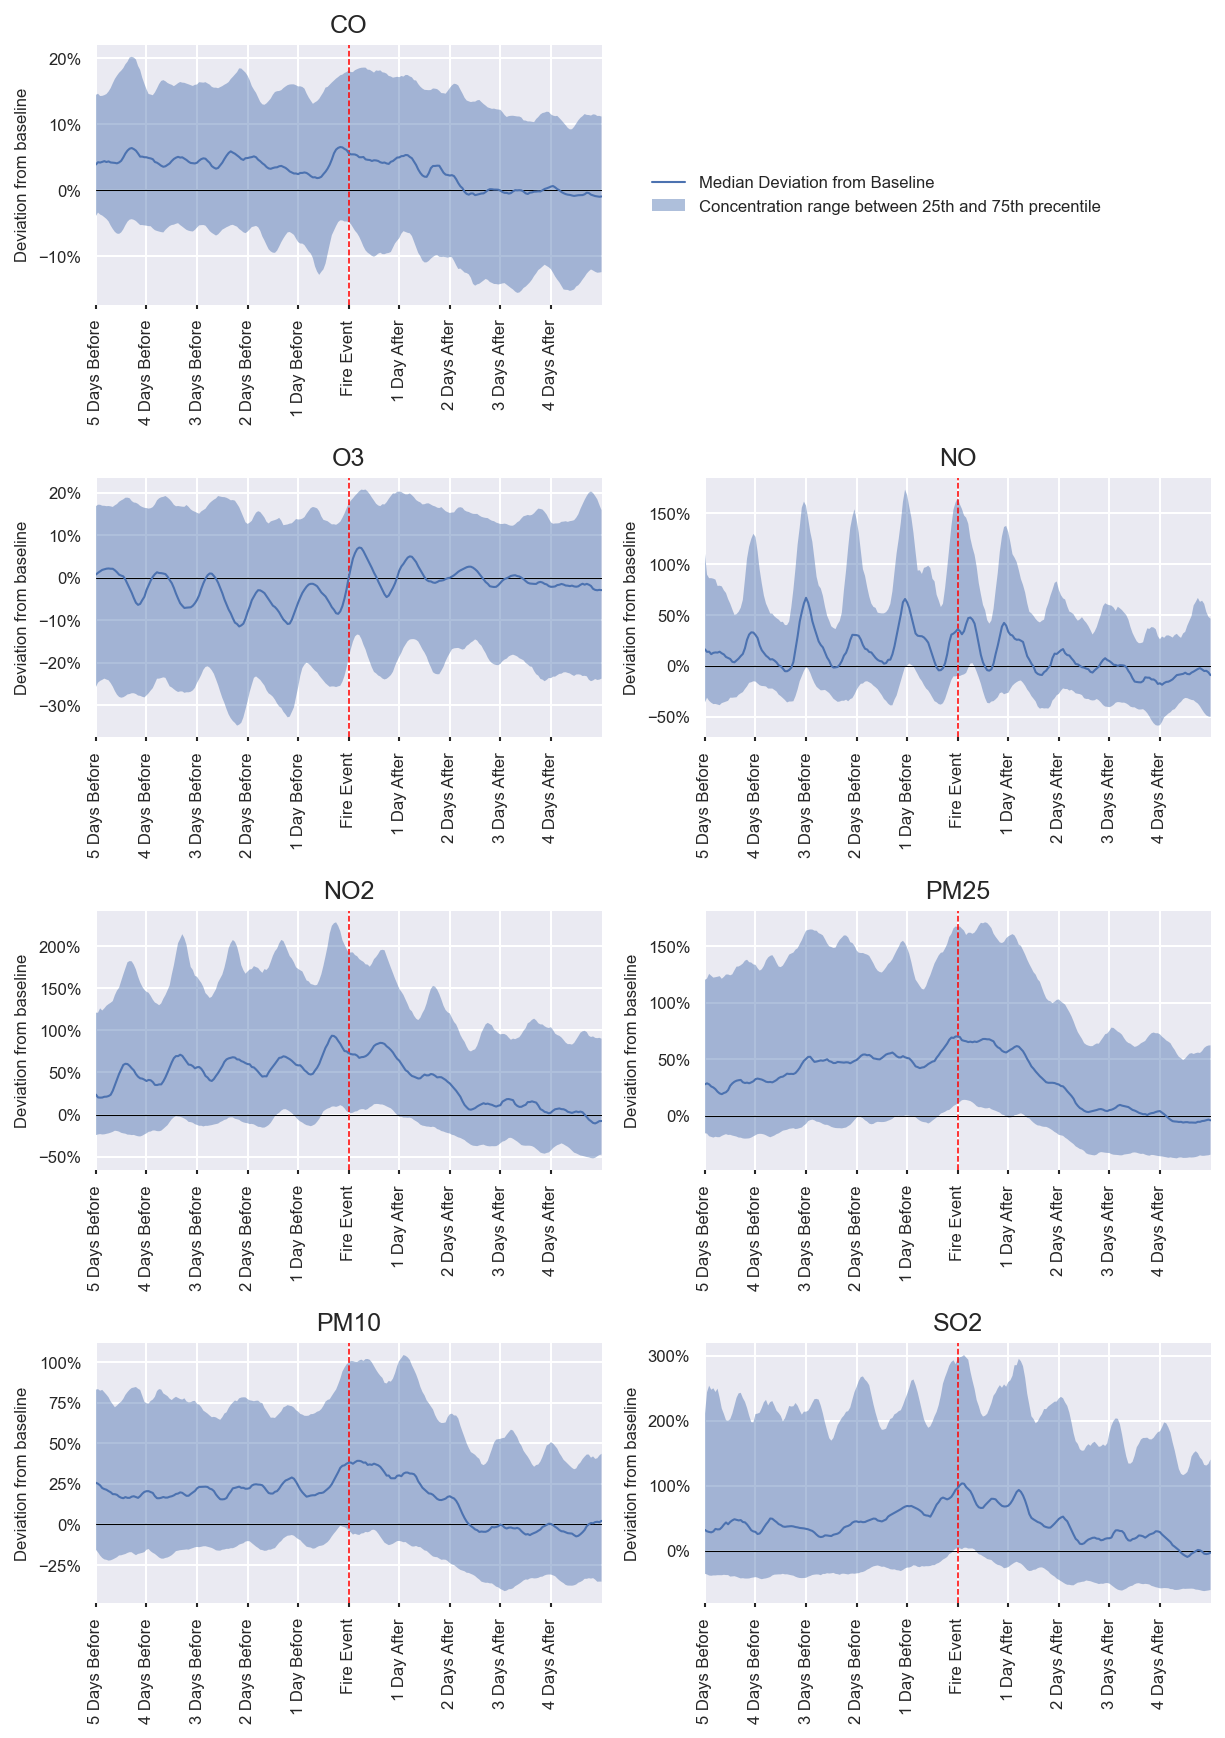

In [227]:
plt.style.use('seaborn')
fig, ax = plt.subplots(4,2, figsize=(8.27, 11.69), dpi=150)
# fig.suptitle('CAMS Reanalysis pollutant distribution per hour of the day for Ireland in 2018.')


positions = {
    0:ax[0][0],
    1:ax[1][0],
    2:ax[1][1],
    3:ax[2][0],
    4:ax[2][1],
    5:ax[3][0],
    6:ax[3][1],
}

for ind, pol in enumerate(POLLUTANTS):
    
    df_spatial = pollutant_difference_percent_pol_sp[pol]
    
    pol_df_sp, mean_df_sp, std_dev_df_sp = get_baseline_stats(df_spatial)
    
    df_temporal = pollutant_difference_percent_pol_tp[pol]
    
    pol_df_tp, mean_df_tp, std_dev_df_tp = get_baseline_stats(df_temporal)
    
    df_spatiotemporal = pollutant_difference_percent_pol_sptp[pol]
    
    pol_df_sptp, mean_df_sptp, std_dev_df_sptp = get_baseline_stats(df_spatiotemporal)
    
    cols = [int(float(col)) for col in pol_df_temporal.columns] # get the value range for the x axis,
    
    positions[ind].axhline(y=0, color='black', linewidth=0.5)
    positions[ind].axvline(x=0, color='red', linestyle='--', linewidth=0.75)
    
    positions[ind].set_xlim([cols[0], cols[-1]])
    
    lower = pol_df_tp.loc[0.25].rolling(6, min_periods=1).mean()
    upper = pol_df_tp.loc[0.75].rolling(6, min_periods=1).mean()
    
    
    positions[ind].plot(
        cols,
        pol_df_tp.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='Median Deviation from Baseline',
    )
    
    positions[ind].fill_between(cols, upper, lower, alpha=0.45, label='Concentration range between 25th and 75th precentile')
    
    positions[ind].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
    positions[ind].set_xticks(tickvals)
    positions[ind].set_xticklabels(plot_labels)
    positions[ind].tick_params(axis="x", labelsize=8, labelrotation=90, pad=5)
    positions[ind].tick_params(axis="y", labelsize=8)
    
    positions[ind].tick_params(axis="x", direction="out", length=2)
    
    positions[ind].set_title(pol)
    positions[ind].grid(True)
    positions[ind].set_ylabel('Deviation from baseline', fontsize=8)


ax[0][1].set_visible(False)
fig.legend(   # The labels for each line
    handles=ax[0][0].__dict__['lines'][2:] + ax[0][0].__dict__['collections'],
    loc="upper right",   # Position of legend
    bbox_to_anchor=(0.4, 0.4, 0.5, 0.5),
    borderaxespad=0.1,    # Small spacing around legend box
    fontsize=8,
    title_fontsize=12,
)
           

fig.tight_layout()
plt.savefig(OUTPUT_DIR.joinpath('temporal_baseline_deviation_overview.png'))
plt.show()

In [6]:
csv_loc = Path(DATA_DIR_PLOTS).joinpath('analysis/baseline_deviation/temporal/csv')

pollutant_difference_percent_pol_modis = {}
pollutant_difference_percent_pol_suomi = {}
pollutant_difference_percent_pol_noaa = {}
pollutant_difference_percent_pol_fb = {}

for pol in POLLUTANTS_TO_ANALYSE:  
    
    df_perc_modis = pd.read_csv(f'{csv_loc}/{pol}_percentage.csv', header=1).set_index('hours_from_fe')
    df_perc_suomi = pd.read_csv(f'{csv_loc}/{pol}_sat_suomi_percentage.csv', header=1).set_index('hours_from_fe')
    df_perc_noaa = pd.read_csv(f'{csv_loc}/{pol}_sat_noaa_percentage.csv', header=1).set_index('hours_from_fe')
    df_perc_fb = pd.read_csv(f'{csv_loc}/{pol}_fb_leinster_forest_percentage.csv', header=1).set_index('hours_from_fe')
    
    pollutant_difference_percent_pol_modis[pol] = df_perc_modis.copy()
    pollutant_difference_percent_pol_suomi[pol] = df_perc_suomi.copy()
    pollutant_difference_percent_pol_noaa[pol] = df_perc_noaa.copy()
    pollutant_difference_percent_pol_fb[pol] = df_perc_fb.copy()

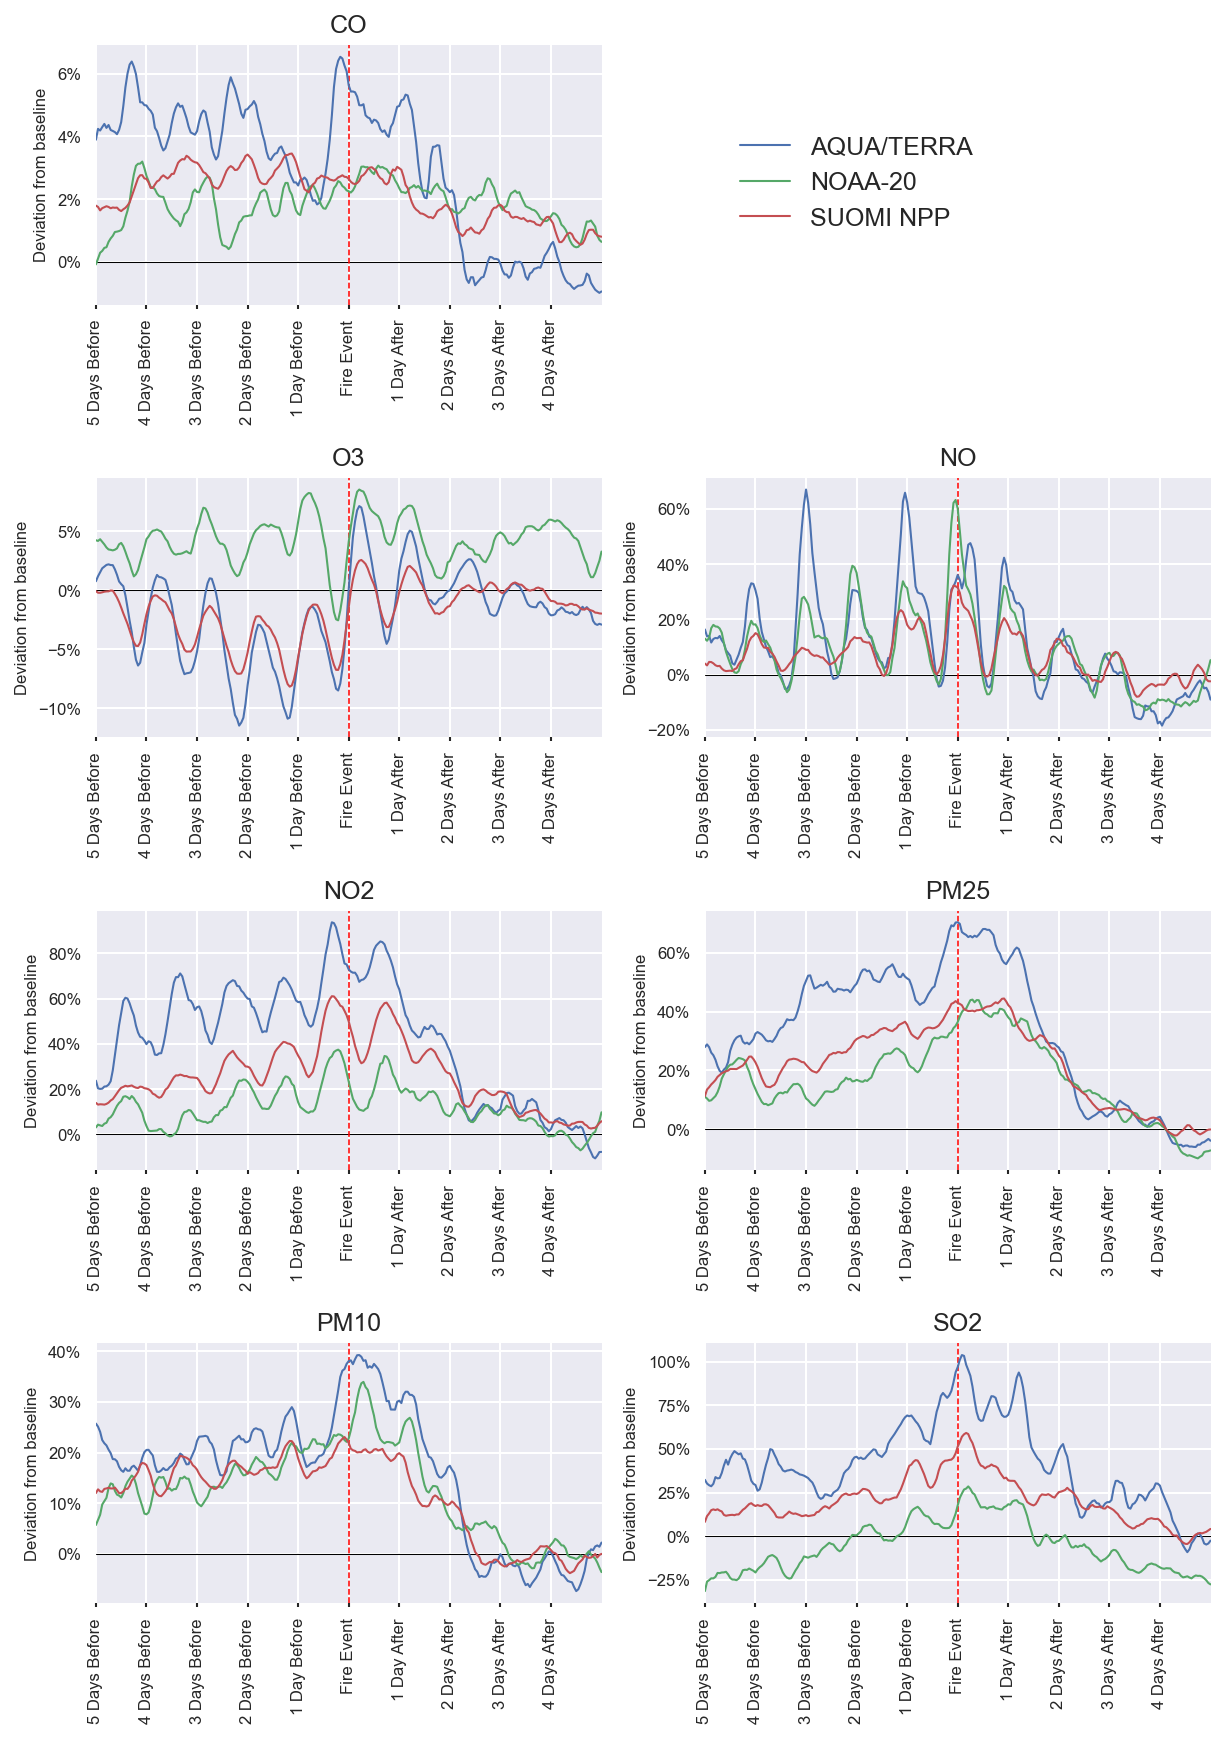

In [34]:
plt.style.use('seaborn')
fig, ax = plt.subplots(4,2, figsize=(8.27, 11.69), dpi=150)
# fig.suptitle('CAMS Reanalysis pollutant distribution per hour of the day for Ireland in 2018.')


positions = {
    0:ax[0][0],
    1:ax[1][0],
    2:ax[1][1],
    3:ax[2][0],
    4:ax[2][1],
    5:ax[3][0],
    6:ax[3][1],
}

for ind, pol in enumerate(POLLUTANTS):
    
    df_modis = pollutant_difference_percent_pol_modis[pol]
    pol_df_modis, mean_df_modis, std_dev_df_modis = get_baseline_stats(df_modis)
    
    df_suomi = pollutant_difference_percent_pol_suomi[pol]
    pol_df_suomi, mean_df_suomi, std_dev_df_suomi = get_baseline_stats(df_suomi)
    
    df_noaa = pollutant_difference_percent_pol_noaa[pol]
    pol_df_noaa, mean_df_noaa, std_dev_df_noaa = get_baseline_stats(df_noaa)
    
    df_fb = pollutant_difference_percent_pol_fb[pol]
    pol_df_fb, mean_df_fb, std_dev_df_fb = get_baseline_stats(df_fb)
       
    cols = [int(float(col)) for col in pol_df_modis.columns] # get the value range for the x axis,
    
    plot_labels = [
        f'{abs(int(x/24))} Days Before'.replace("1 Days", "1 Day") if x < 0 else f'{int(x/24)} Days After'.replace("0 Days After", "Fire Event").replace("1 Days", "1 Day") for x in list(
                    range(
                        int(float(list(df_modis.columns)[0])),
                        int(float(list(df_modis.columns)[-1])),
                        24
    ))]

    tickvals=[x for x in list(
                range(
                        int(float(list(df_modis.columns)[0])),
                        int(float(list(df_modis.columns)[-1])),
                        24
                    )
            )]
    
    positions[ind].axhline(y=0, color='black', linewidth=0.5)
    positions[ind].axvline(x=0, color='red', linestyle='--', linewidth=0.75)
    
    positions[ind].set_xlim([cols[0], cols[-1]])
    
    
    positions[ind].plot(
        cols,
        pol_df_modis.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='AQUA/TERRA',
    )
    
    positions[ind].plot(
        cols,
        pol_df_noaa.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='NOAA-20',
    )
    
    positions[ind].plot(
        cols,
        pol_df_suomi.loc[0.5].rolling(6, min_periods=1).mean(),
        linewidth=1.0,
        label='SUOMI NPP',
    )
    
#     positions[ind].plot(
#         cols,
#         pol_df_fb.loc[0.5].rolling(6, min_periods=1).mean(),
#         linewidth=1.0,
#         label='Leinster Fire Brigade (Forest Fires)',
#     )
    
    
    positions[ind].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
    positions[ind].set_xticks(tickvals)
    positions[ind].set_xticklabels(plot_labels)
    positions[ind].tick_params(axis="x", labelsize=8, labelrotation=90, pad=5)
    positions[ind].tick_params(axis="y", labelsize=8)
    
    positions[ind].tick_params(axis="x", direction="out", length=2)
    
    positions[ind].set_title(pol)
    positions[ind].grid(True)
    positions[ind].set_ylabel('Deviation from baseline', fontsize=8)


ax[0][1].set_visible(False)
fig.legend(   # The labels for each line
    handles=ax[0][0].__dict__['lines'][2:],
    loc="upper right",   # Position of legend
    bbox_to_anchor=(0.3, 0.425, 0.5, 0.5),
    borderaxespad=0.1,    # Small spacing around legend box
    fontsize=12,
#     title='Deviation from baseline:',
    title_fontsize=17,
)
           

fig.tight_layout()
plt.savefig(OUTPUT_DIR.joinpath('temporal_baseline_deviation_all_firms_satellites.png'))
plt.show()